# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

from benchmarks.generator import get_revenue_behavior_deprecated
from benchmarks.utils import int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart

from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Supply

from pathlib import Path
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   3
RU3                   7
RU1                   5
RU4                   5
RU5                   5


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  25


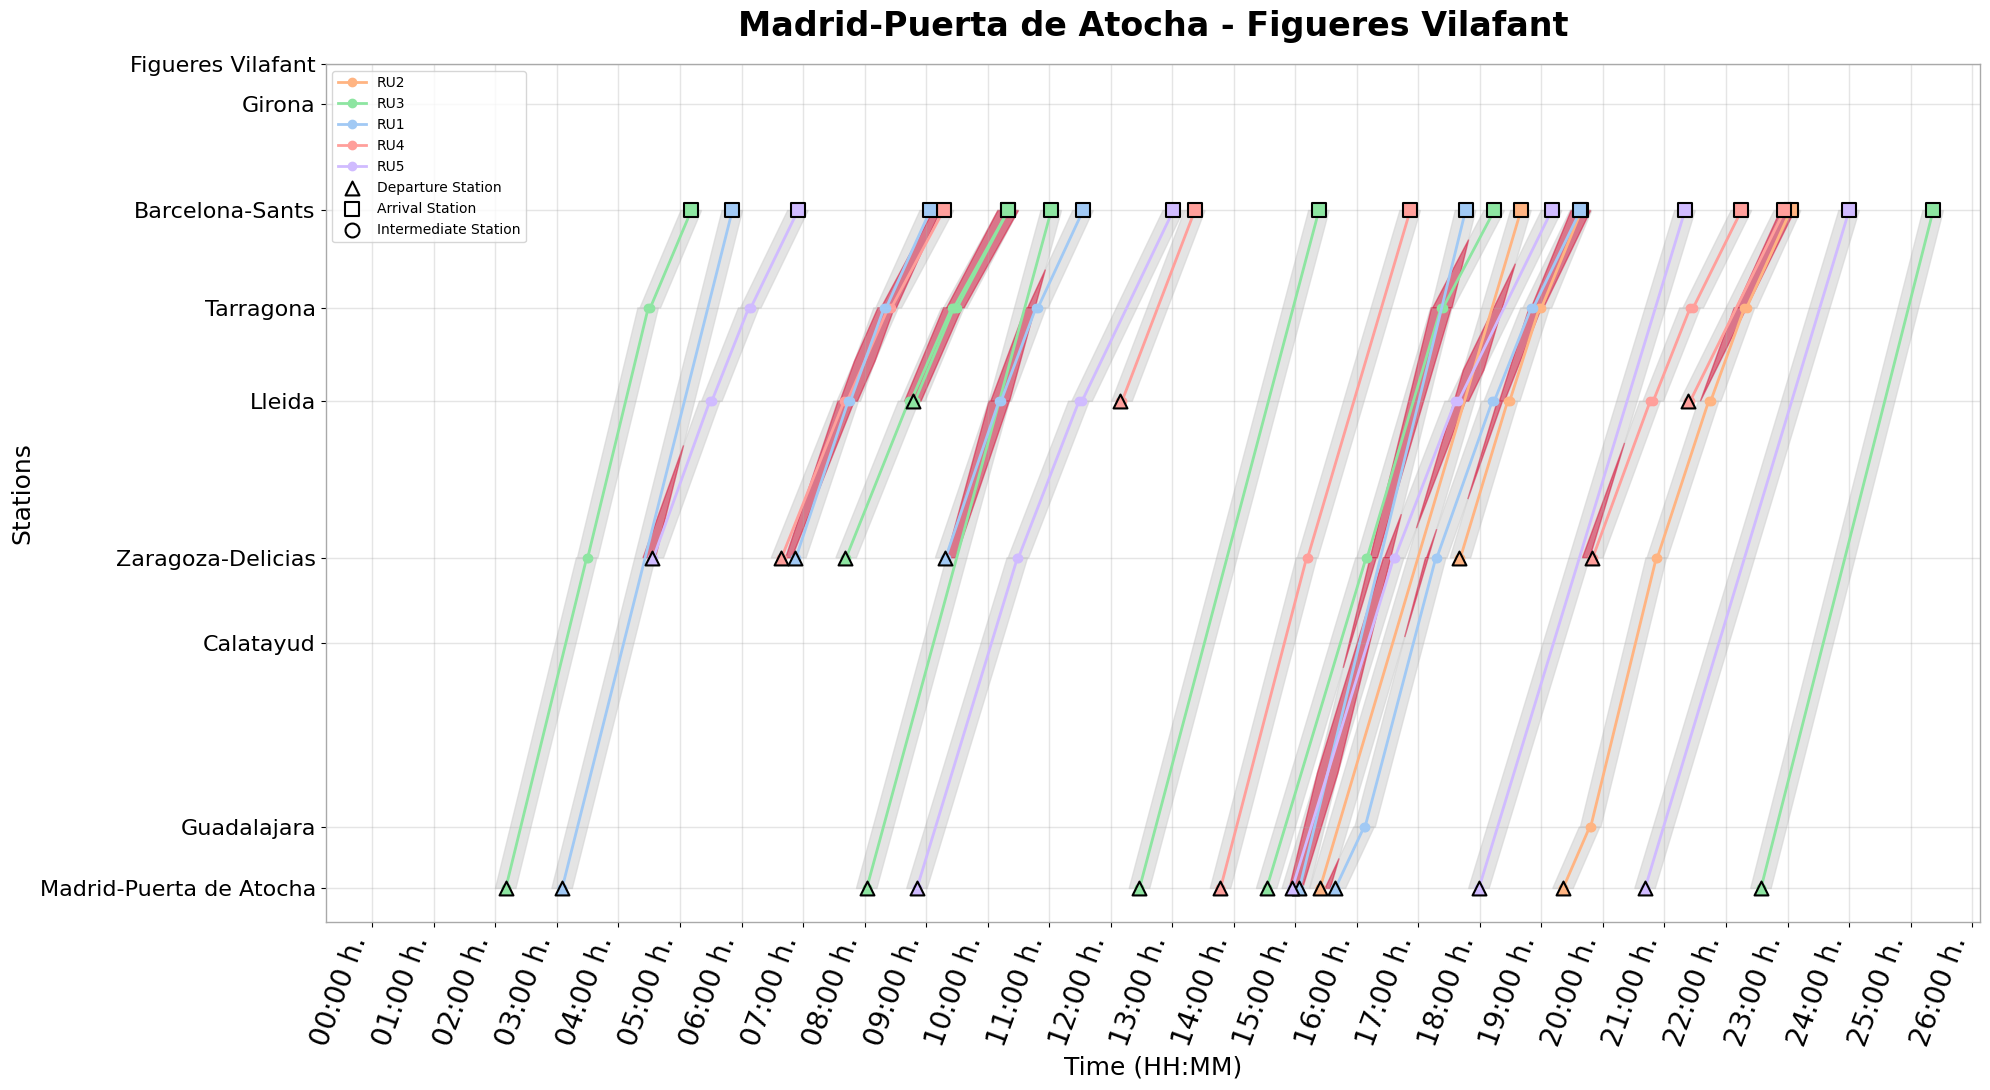

In [6]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/escim2025/'
)

## 1. Pyomo

In [7]:
from src.timetabling_problem import MPTT

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behaviour,
    line=line,
    safe_headway=10
)

In [ ]:
travel_times = {}
dwell_times = {}
lower_bounds = {}
upper_bounds = {}
for service in supply.services:
    for i, (station, (arrival, departure)) in enumerate(service.schedule.items(), start=1):
        if i == len(service.schedule) - 1:
            break
        travel_times[(service.id, i)] = (tuple(service.schedule.values())[i+1][0] - departure).total_seconds() / 60
        dwell_times[(service.id, i)] = (departure - arrival).total_seconds() / 60
        lower_bounds[(service.id, i)] = departure.total_seconds() // 60 - 60
        upper_bounds[(service.id, i)] = departure.total_seconds() // 60 + 60

In [16]:
def bounds_schedule_times(model, service, station):
    return (lower_bounds[(service, station)], upper_bounds[(service, station)])

In [20]:
import pyomo.environ as pyo

model = pyo.ConcreteModel()

service_station_idx = list(travel_times.keys())
services_names = list(dict.fromkeys(mptt.service_indexer))

model.requests = pyo.Set(initialize=service_station_idx, dimen=2)
model.schedule_times = pyo.Var(model.requests, within=pyo.NonNegativeReals, bounds=bounds_schedule_times)
model.is_scheduled = pyo.Var(services_names, within=pyo.Binary)

model.travel_time = pyo.Param(model.requests, initialize=travel_times, within=pyo.NonNegativeReals)
model.dwell_time = pyo.Param(model.requests, initialize=dwell_times, within=pyo.NonNegativeReals)

@model.Objective(sense=pyo.maximize)
def objective_function(model):
    return sum(model.is_scheduled[service_id] * revenue_behaviour[service_id]['canon'] for service_id in services_names)

def departure_time_rule(model, service, j):
    if j == 1:
        return pyo.Constraint.Skip
    return (
        model.schedule_times[(service, j)] * model.is_scheduled[service]
        >= (model.schedule_times[(service, j-1)]
           + model.travel_time[(service, j-1)]
           + model.dwell_time[(service, j)]) * model.is_scheduled[service]
    )

model.departure_time_restriction = pyo.Constraint(model.requests, rule=departure_time_rule)

In [26]:
opt = pyo.SolverFactory('scip')
result_obj = opt.solve(model, tee=True)

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.4] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  SoPlex 7.1.4         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 7c53d552]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  TinyCThread 1.2      small portable implementation of the C11 threads API (tinycthread.github.io)
  GMP 6.2.1            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.6.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.2         parallel presolve for integer and linear optimization (github.com

In [27]:
model.pprint()

1 Set Declarations
    requests : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   32 : {('0_2025-06-25-17.40', 1), ('0_2025-06-25-17.40', 2), ('1_2025-06-25-14.32', 1), ('1_2025-06-25-14.32', 2), ('3_2025-06-25-13.47', 1), ('6_2025-06-25-2.10', 1), ('6_2025-06-25-2.10', 2), ('8_2025-06-25-8.51', 1), ('8_2025-06-25-8.51', 2), ('12_2025-06-25-6.38', 1), ('12_2025-06-25-6.38', 2), ('13_2025-06-25-15.39', 1), ('13_2025-06-25-15.39', 2), ('13_2025-06-25-15.39', 3), ('13_2025-06-25-15.39', 4), ('14_2025-06-25-19.21', 1), ('14_2025-06-25-19.21', 2), ('14_2025-06-25-19.21', 3), ('14_2025-06-25-19.21', 4), ('15_2025-06-25-6.52', 1), ('15_2025-06-25-6.52', 2), ('16_2025-06-25-4.33', 1), ('16_2025-06-25-4.33', 2), ('17_2025-06-25-8.47', 1), ('19_2025-06-25-19.49', 1), ('19_2025-06-25-19.49', 2), ('20_2025-06-25-9.18', 1), ('20_2025-06-25-9.18', 2), ('22_2025-06-25-7.41', 1), ('22_2025-06-25-7.41', 2), ('24_2025-06-25-14.57', 1